In [1]:
#|default_exp 03.01_app

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
torch.manual_seed(42)
import tsensor
# Get rid of findfont: Font family 'Arial' not found.
# when running a remote notebook on Jupyter Server on Ubuntu Linux server
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

from lolviz import *


mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Foundations Version

### Basic Architecture

- Assign the number of items in our training set to `n` - where `n` is the number of training examples
- Assign the number of pixels in each item to `m` - where `m` is the number of pixels
- Assign possible values of digits to `c` - where `c` is the possible values of digits

In [3]:
x_train, x_train.shape

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]))

In [4]:
x_train[1, :].shape

torch.Size([784])

In [5]:
x_train[1,:].reshape(28,28).shape

torch.Size([28, 28])

In [6]:
#|export
n,m = x_train.shape
c = y_train.max()+1

- Assign to `nh` an integer for our 50 hidden layers, aka our 50 activation functinons, in this case *relus*

In [7]:
#|export
nh = 50

- Create the weight matrices for multiplication. 
    - The first set of weights, `w1` will be for our training set
    - The weights will also need a bias, `b1` that will begin as zeros 
    - The second set of weights, `w2` will be for our output matrix, which will just  be one output, which is the guess of what number it is
    - The second bias `b2` be initialized as zeros and match `w2`

In [8]:
n,m,c,nh

(50000, 784, tensor(10), 50)

In [9]:
#|export
w1 = torch.randn(m,nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)
b2 = torch.zeros(1)

In [10]:
w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([784, 50]), torch.Size([50]), torch.Size([50, 1]), torch.Size([1]))

In [11]:
(x_train@w1) + b2

tensor([[ 12.53,  10.99,  -2.58,  ...,   6.05,  -0.14,  11.34],
        [ 28.33,   6.83,   4.17,  ..., -13.48, -14.75,  17.52],
        [  5.67,  -5.26,   0.55,  ...,  -1.61,   4.13,   4.68],
        ...,
        [  1.14,   2.96, -14.34,  ...,   1.26,   4.31,  19.45],
        [ -6.83,   4.90,  -4.14,  ...,   2.80,  -1.42,  12.29],
        [  8.51,  14.52,  -7.94,  ...,  14.50,   1.10,  18.45]])

In [12]:
y_train.shape

torch.Size([50000])

- Create a function `lin` to perform matrix multiplication and add the bias 

In [13]:
#|export
def lin(x, w, b):
    return x@w + b

In [14]:
x_valid.shape

torch.Size([10000, 784])

In [15]:
t = lin(x_valid, w1, b1)
t.shape

torch.Size([10000, 50])

In [16]:
t

tensor([[ -0.09,  11.87, -11.39,  ...,   5.48,   2.14,  15.30],
        [  5.38,  10.21, -14.49,  ...,   0.88,   0.08,  20.23],
        [  3.31,   0.12,   3.10,  ...,  16.89,  -6.05,  24.74],
        ...,
        [  4.01,  10.35, -11.25,  ...,   0.23,  -5.30,  18.28],
        [ 10.62,  -4.27,  10.72,  ...,  -2.87,  -2.87,  18.23],
        [  2.84,  -0.22,   1.43,  ...,  -3.91,   5.75,   2.12]])

- Create a `relu` function to flatten values at 0

In [17]:
#|export
def relu(x):
    return x.clamp_min(0.)

In [18]:
relu(x_train@w1 + b1)

tensor([[12.53, 10.99,  0.00,  ...,  6.05,  0.00, 11.34],
        [28.33,  6.83,  4.17,  ...,  0.00,  0.00, 17.52],
        [ 5.67,  0.00,  0.55,  ...,  0.00,  4.13,  4.68],
        ...,
        [ 1.14,  2.96,  0.00,  ...,  1.26,  4.31, 19.45],
        [ 0.00,  4.90,  0.00,  ...,  2.80,  0.00, 12.29],
        [ 8.51, 14.52,  0.00,  ..., 14.50,  1.10, 18.45]])

In [19]:
t = relu(t)
t

tensor([[ 0.00, 11.87,  0.00,  ...,  5.48,  2.14, 15.30],
        [ 5.38, 10.21,  0.00,  ...,  0.88,  0.08, 20.23],
        [ 3.31,  0.12,  3.10,  ..., 16.89,  0.00, 24.74],
        ...,
        [ 4.01, 10.35,  0.00,  ...,  0.23,  0.00, 18.28],
        [10.62,  0.00, 10.72,  ...,  0.00,  0.00, 18.23],
        [ 2.84,  0.00,  1.43,  ...,  0.00,  5.75,  2.12]])

In [20]:
(x_train@w1 + b1).shape

torch.Size([50000, 50])

- Create a `model` function to take a mini-batch `xs`
    - Create the first linear layer
    - Put first linear layer through a relu
    - Pass the relu-ed first linear layer through the second linear layer and return the value

In [21]:
#|export
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

In [22]:
lin(relu(x_train@w1 + b1), w2, b2),lin(relu(x_train@w1 + b1), w2, b2).shape

(tensor([[-30.97],
         [-99.38],
         [  8.72],
         ...,
         [-52.12],
         [-46.25],
         [ -4.35]]),
 torch.Size([50000, 1]))

- Pass the validation set through the model to check if working

In [23]:
#|export
res = model(x_valid)
res

tensor([[  25.75],
        [ -13.06],
        [-114.79],
        ...,
        [ -67.44],
        [ -74.48],
        [ -60.19]])

### Loss Function MSE

- Subtract `y_valid` from `res` and think about how broadcasting rules apply here

In [24]:
res.shape, y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

- Subtract the validation from the model results 

In [25]:
(res-y_valid).shape

torch.Size([10000, 10000])

- adjust to add a unit axis to correct the output from broadcasting

In [26]:
(res-y_valid[:,None]).shape, (res-y_valid[:,None])

(torch.Size([10000, 1]),
 tensor([[  22.75],
         [ -21.06],
         [-120.79],
         ...,
         [ -72.44],
         [ -80.48],
         [ -68.19]]))

- remove a unit axis to correct the output from broadcasting

In [27]:
(res[:,0] - y_valid).shape

torch.Size([10000])

In [28]:
#|export
y_train, y_valid = y_train.float(), y_valid.float()

create predictions

In [29]:
#|export
preds = model(x_train)

In [30]:
preds.shape

torch.Size([50000, 1])

create a mean squared error function

In [31]:
#|export
def mse(output, target):
    return (output[:,0] - target).pow(2).mean()

In [32]:
mse(preds, y_train)

tensor(4308.76)

## Gradients and Backward Pass

In [33]:
from sympy import symbols, diff
x,y = symbols('x y')
diff(x**2, x)

2*x

In [34]:
diff(3*x**2 + 9, x)

6*x

***

In [35]:
x_res = model(x_train)

In [36]:
(x_res[:,0] - y_train)

tensor([-35.97, -99.38,   4.72,  ..., -60.12, -50.25, -12.35])

In [37]:
(x_res[:,0] - y_train).pow(2).mean()

tensor(4308.76)

In [38]:
(x_res[:,0] - y_train)[:, None]

tensor([[-35.97],
        [-99.38],
        [  4.72],
        ...,
        [-60.12],
        [-50.25],
        [-12.35]])

In [39]:
(x_res[:,0] - y_train)[:, None] * 2

tensor([[ -71.94],
        [-198.76],
        [   9.45],
        ...,
        [-120.23],
        [-100.50],
        [ -24.69]])

In [40]:
out_g = ((x_res[:,0] - y_train)[:, None] * 2) / x_res.shape[0]

In [41]:
x_inp_g = out_g@w2.t()
x_inp_g.shape

torch.Size([50000, 50])

In [42]:
out_g

tensor([[-0.00],
        [-0.00],
        [ 0.00],
        ...,
        [-0.00],
        [-0.00],
        [-0.00]])

***

In [43]:
#|export
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [44]:
#|export
def forward_and_backward(inp, targ):
    # forward pass
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    diff = out[:,0] - targ
    loss = diff.pow(2).mean()

    # backward pass
    out.g = 2. * diff[:, None] / inp.shape[0]
    lin_grad(l2, out, w2, b2)
    l1.g = (l1>0).float() * l2.g
    lin_grad(inp, l1, w1, b1)   

In [45]:
#|export
forward_and_backward(x_train, y_train)

In [46]:
# save the gradients for testing later
# define a function that takes x as an argument and returns the gradients of x as a clone
def get_grad(x):
    return x.g.clone()

In [47]:
# return a tuple of all
chks = w1, w2, b1, b2, x_train
# maps the get_grad function to all in chks, returns a tuple of len(chks) which
# are assigned to variables, then assigned to grads
grads = w1g, w2g, b1g, b2g, ig = tuple(map(get_grad, chks)) 

In [48]:
len(grads)

5

Cheat a bit and use pytorch autograd to check results

In [49]:
# create a clone of all chks and set them to require gradient
def mkgrad(x):
    return x.clone().requires_grad_(True)
ptgrads = w12, w22, b12, b22, xt2 = tuple(map(mkgrad, chks))

In [50]:
# create forward pass function for our pytorch data
def forward(inp, targs):
    l1 = lin(inp, w12, b12)
    l2 = relu(l1)
    out = lin(l2, w22, b22)
    return mse(out, targs)

In [51]:
loss = forward(xt2, y_train)
loss.backward()

In [52]:
for a, b in zip(grads, ptgrads):
    test_close(a, b.grad, eps=0.01)

## Refactor Model

### Layers as Classes

In [53]:
#|export
class Relu():
    # create a call function that takes and inp and returns an out that clamps at 0
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0)
        return self.out
    
    # create a backward function that takes inp.g and returns a boolean float and multiply it by the out.g to flatten negatives
    def backward(self):
        self.inp.g = (self.inp > 0).float() * self.out.g

In [54]:
#|export
class Lin():
    # intialize parameters weights and biases, w and b
    def __init__(self, w, b):
        self.w = w
        self.b = b
    # create a call function that takes and input, and runs input with weights and biases through a linear layer function
    def __call__(self, inp):
        self.inp = inp
        self.out = lin(inp, self.w, self.b)
        return self.out
    # create a backward function that gets the dot product of the output
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = self.inp.t() @ self.out.g
        self.b.g = self.out.g.sum()

In [55]:
#|export
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = mse(inp, targ)
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [56]:
#|export
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [57]:
#|export
model = Model(w1, b1, w2, b2)

In [58]:
#|export
loss = model(x_train, y_train)

In [59]:
#|export
model.backward()

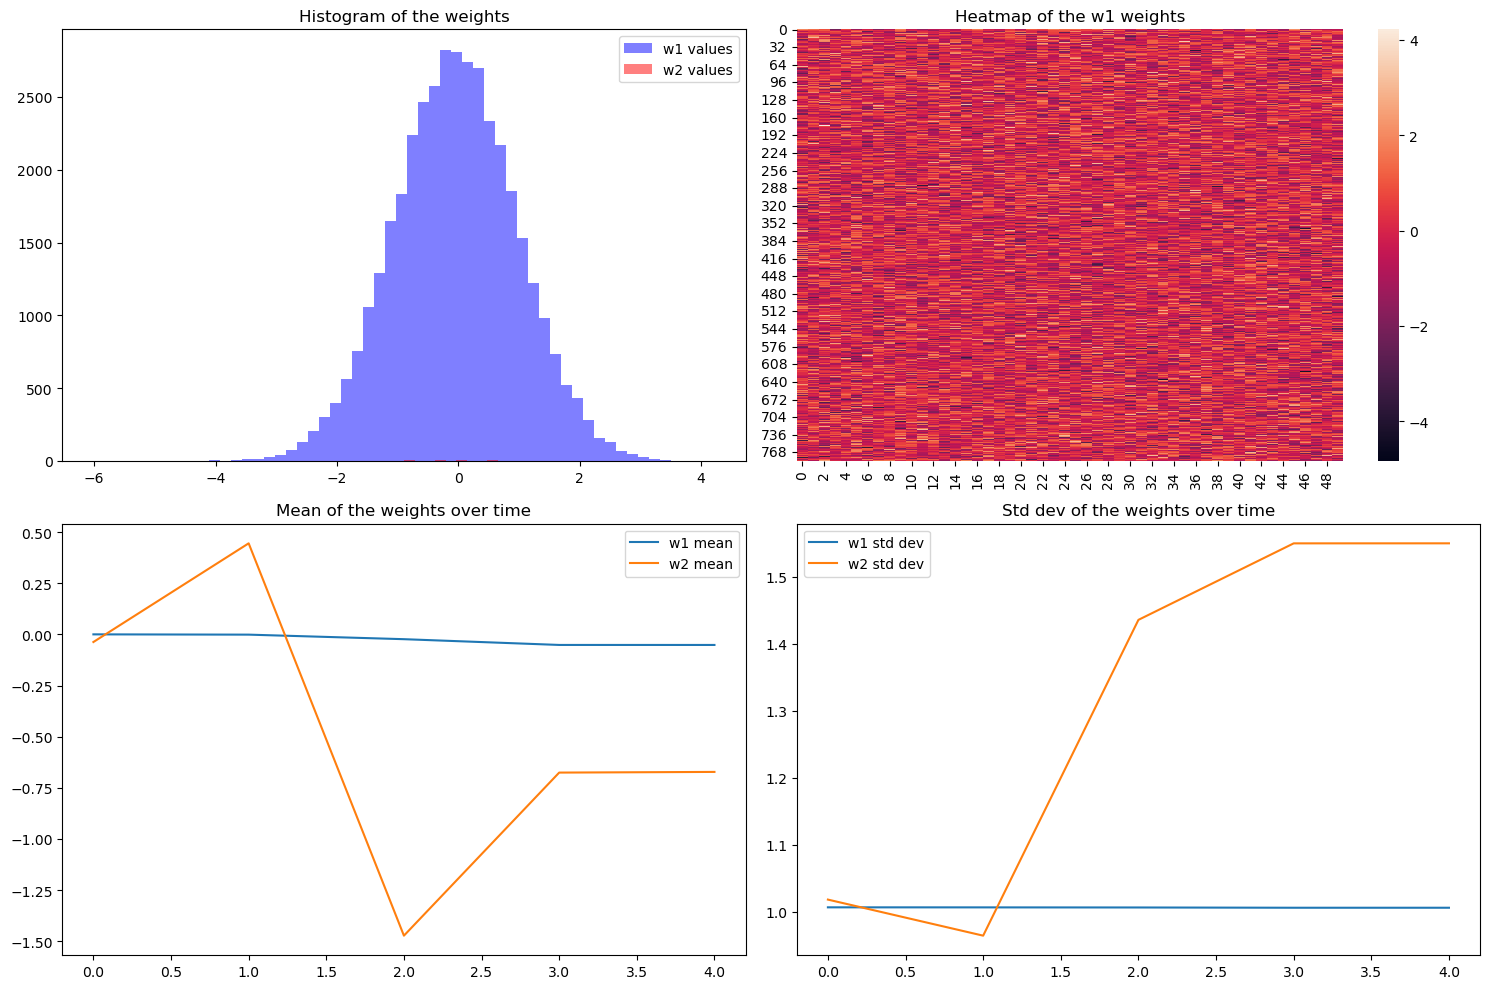

In [66]:
import seaborn as sns

lr = 1e-3
w1_vals, w1_grads = [], []
w2_vals, w2_grads = [], []

for epoch in range(5):
    forward_and_backward(x_train, y_train)
    # store weights and gradients for later plotting
    w1_vals.append(w1.clone().detach())
    w1_grads.append(w1.g.clone().detach())
    w2_vals.append(w2.clone().detach())
    w2_grads.append(w2.g.clone().detach())
    # update weights and biases using gradients
    with torch.no_grad():
        w1 -= w1.g * lr
        b1 -= b1.g * lr
        w2 -= w2.g * lr
        b2 -= b2.g * lr
        w1.g.zero_()
        b1.g.zero_()
        w2.g.zero_()
        b2.g.zero_()

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Histograms of the weights
axs[0, 0].hist(w1_vals[-1].numpy().flatten(), bins=50, color='blue', alpha=0.5, label='w1 values')
axs[0, 0].hist(w2_vals[-1].numpy().flatten(), bins=50, color='red', alpha=0.5, label='w2 values')
axs[0, 0].legend()
axs[0, 0].set_title('Histogram of the weights')

# Heatmaps of the weights
sns.heatmap(w1_vals[-1], ax=axs[0, 1])
axs[0, 1].set_title('Heatmap of the w1 weights')

# Plot mean of the weights over time
axs[1, 0].plot([w.mean().item() for w in w1_vals], label='w1 mean')
axs[1, 0].plot([w.mean().item() for w in w2_vals], label='w2 mean')
axs[1, 0].legend()
axs[1, 0].set_title('Mean of the weights over time')

# Plot std dev of the weights over time
axs[1, 1].plot([w.std().item() for w in w1_vals], label='w1 std dev')
axs[1, 1].plot([w.std().item() for w in w2_vals], label='w2 std dev')
axs[1, 1].legend()
axs[1, 1].set_title('Std dev of the weights over time')

plt.tight_layout()
plt.show()


In [60]:
import nbdev

In [61]:
nbdev.export.nb_export('03.01_backpropagation_rebuild.ipynb', '03.01_app')